In [ ]:
import datetime

import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cpu


In [ ]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [ ]:
training_dataloader = DataLoader(training_data, batch_size=128) #, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)

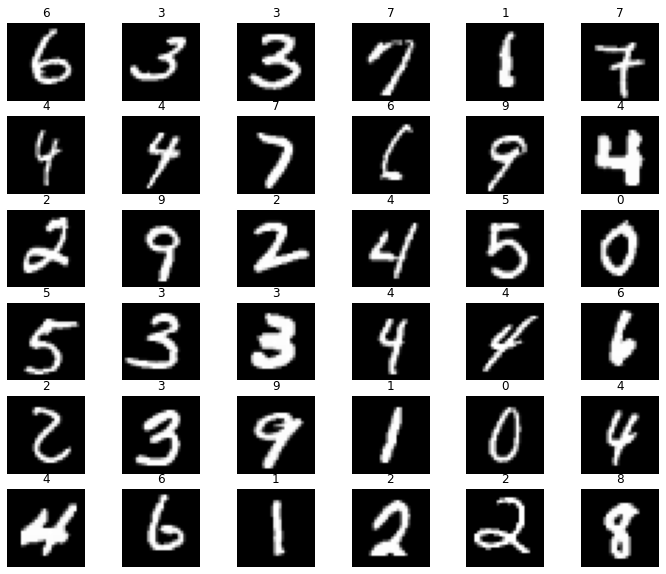

In [ ]:
figure = plt.figure(figsize=(12, 10))
cols, rows = 6, 6
for i in range(1, cols * rows + 1):
  idx = torch.randint(len(training_data), size=(1,))
  img, label = training_data[idx[0]]
  figure.add_subplot(rows, cols, i)
  plt.title(label)
  plt.axis('off')
  plt.imshow(img.squeeze(), cmap='gray')

In [ ]:
class Encoder(nn.Module):
  def __init__(self, latent_l_size):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(
          in_channels=1,
          out_channels=16,
          kernel_size=5,
          stride=1,
          padding=2
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
      nn.Conv2d(16,32,5,1,2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
    )
    self.out = nn.Linear(32*7*7, latent_l_size)

  def forward(self, x):
    x = self.conv(x)
    x = x.view(x.size(0), -1)
    x = self.out(x)
    return x


class Decoder(nn.Module):
  def __init__(self, latent_l_size):
    super().__init__()
    self.lin = nn.Sequential(
        nn.Linear(latent_l_size, 32*7*7)
    )
    self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 7, 7))
    self.conv = nn.Sequential(
        nn.ConvTranspose2d(
          in_channels = 32,
          out_channels = 16,
          kernel_size = 5,
          stride=2,
          padding=2,
          output_padding=1
        ),
        nn.ReLU(),
        nn.ConvTranspose2d(16,1,5,
          stride=2,
          padding=2,
          output_padding=1),
        nn.Sigmoid()
    )


  def forward(self, x):
    x = self.lin(x)
    x = self.unflatten(x)
    x = self.conv(x)
    return x

In [ ]:
enc = Encoder(2)
enc

Encoder(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=2, bias=True)
)

In [ ]:
dec = Decoder(2)
dec

Decoder(
  (lin): Sequential(
    (0): Linear(in_features=2, out_features=1568, bias=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 7, 7))
  (conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (3): Sigmoid()
  )
)

In [ ]:
len(training_data[0][0][0])

28

In [ ]:
summary(enc, (1, 28, 28))
summary(dec, [[2]])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]          12,832
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Linear-7                    [-1, 2]           3,138
Total params: 16,386
Trainable params: 16,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 0.06
Estimated Total Size (MB): 0.39
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output S

In [ ]:
params_to_optimize = [
    {'params': enc.parameters()},
    {'params': dec.parameters()}
]
optimizer = optim.Adam(params_to_optimize, lr=0.001, weight_decay=1e-05)
print(optimizer)
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()
print(loss_fn)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 1e-05

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 1e-05
)
MSELoss()


In [ ]:
def train_epoch(enc, dec, dataloader, loss_fn, optimizer):
  enc.train()
  dec.train()
  loss_l = []

  for img_batch, _ in dataloader:
    encoded_data = enc(img_batch)
    decoded_data = dec(encoded_data)

    loss = loss_fn(decoded_data, img_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_l.append(loss.item())
  return loss_l


In [ ]:
def train(enc, dec, dataloader, loss_fn, optimizer, epochs_n):
  loss_l = []
  for e in range(epochs_n):
    timer = datetime.datetime.now()
    epoch_losses = train_epoch(enc, dec, dataloader, loss_fn, optimizer)
    print("E {}: training loss = {}, time: {}".format(
        e,
        sum(epoch_losses),
        datetime.datetime.now() - timer
        ))
    loss_l += epoch_losses


In [ ]:
train(enc, dec, training_dataloader, loss_fn, optimizer, 5)

E 0: training loss = 22.422141391783953
[0.046608321368694305, 0.04884590581059456, 0.04569508507847786, 0.045035120099782944, 0.045751046389341354, 0.047750458121299744, 0.050155431032180786, 0.04761175066232681, 0.045205630362033844, 0.054259639233350754, 0.053544871509075165, 0.04903089255094528, 0.04743623733520508, 0.04447751119732857, 0.04834549129009247, 0.049861643463373184, 0.0474928580224514, 0.047905825078487396, 0.04547443613409996, 0.04673067852854729, 0.04839877784252167, 0.049696847796440125, 0.04975827410817146, 0.04727081209421158, 0.042835500091314316, 0.04216401278972626, 0.04608738049864769, 0.045420851558446884, 0.05359477549791336, 0.04902208596467972, 0.04514705017209053, 0.048206523060798645, 0.045926861464977264, 0.04560241103172302, 0.04726245626807213, 0.047685593366622925, 0.054810781031847, 0.05475302040576935, 0.045895062386989594, 0.047590021044015884, 0.04706786572933197, 0.050114843994379044, 0.05080023035407066, 0.048332903534173965, 0.0494625717401504

In [ ]:
def plot_output(enc, dec, data_set, n=10):
  figure = plt.figure(figsize=(20,4+rows))
  first_row = True
  targets = data_set.targets.numpy()
  t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
  enc.eval()
  dec.eval()
  for i in range(n):
    img = data_set[t_idx[i]][0].unsqueeze(0)
    label = data_set[t_idx[i]][1]
    figure.add_subplot(rows, n, i+1)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')

    with torch.no_grad():
      minced_img = dec(enc(img))
    img = img[0].unsqueeze(0)
    figure.add_subplot(rows, n, n+i+1)
    plt.axis('off')
    plt.imshow(minced_img.squeeze(), cmap='gray')


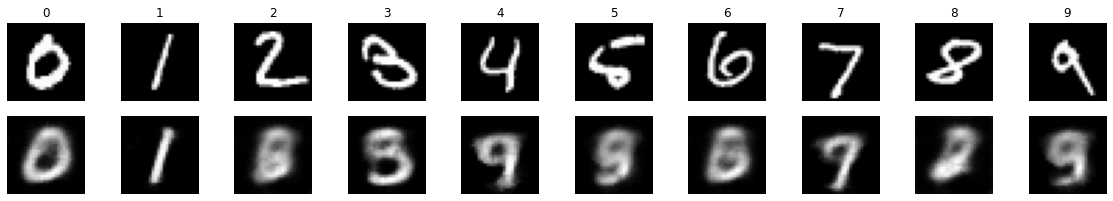

In [ ]:

plot_output(enc, dec, test_data)

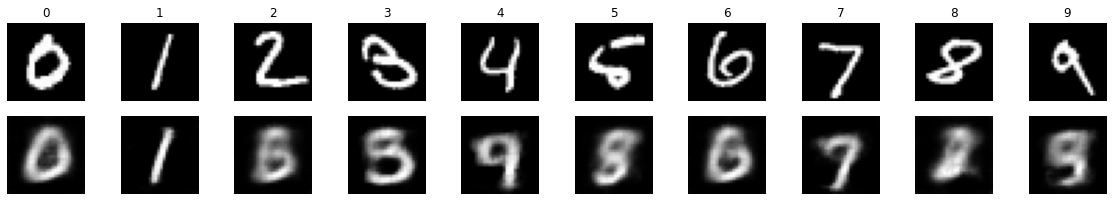

In [ ]:
plot_output(enc, dec, test_data)